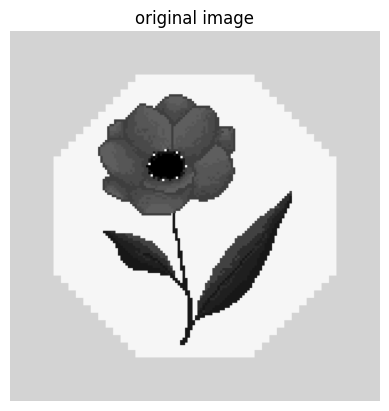

In [40]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

image_path = '/content/image.jpg'

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # jako skala szarości

# poprawność wczytania
if img is not None:
    plt.imshow(img, cmap='gray')
    plt.title("original image")
    plt.axis('off')
    plt.show()
else:
    print("ERROR: no image found.")


# operacje morfologiczne





dylatacja i erozja

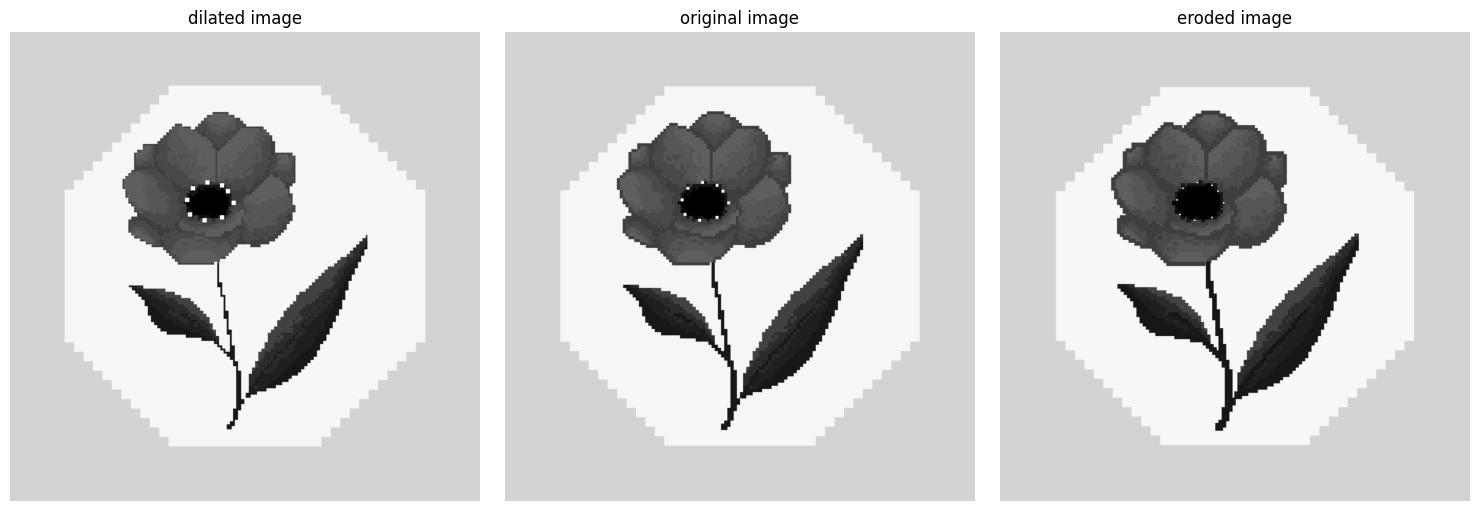

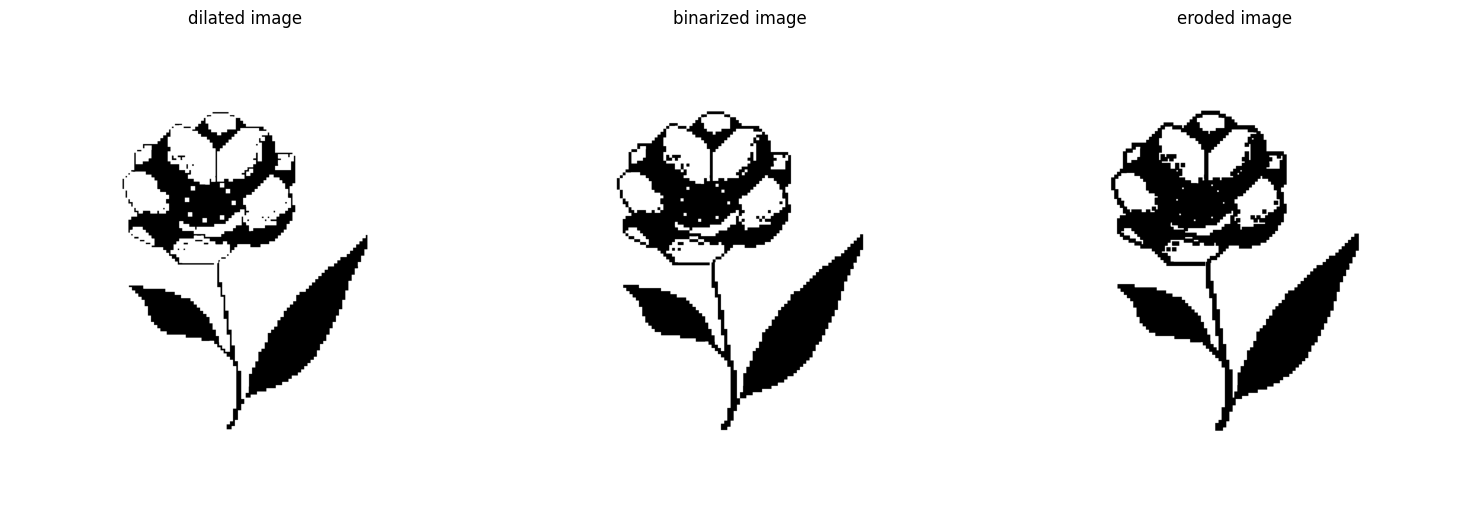

In [41]:
# dylatacja i erozja z promieniem radius
def dilate(image, radius):
    kernel = np.ones((2*radius+1, 2*radius+1), np.uint8)
    return cv2.dilate(image, kernel, iterations=1)

def erode(image, radius):
    kernel = np.ones((2*radius+1, 2*radius+1), np.uint8)
    return cv2.erode(image, kernel, iterations=1)

radius = 3

dilated_img = dilate(img, radius)
eroded_img = erode(img, radius)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(dilated_img, cmap='gray')
axes[0].set_title('dilated image')
axes[0].axis('off')

axes[1].imshow(img, cmap='gray')
axes[1].set_title('original image')
axes[1].axis('off')

axes[2].imshow(eroded_img, cmap='gray')
axes[2].set_title('eroded image')
axes[2].axis('off')

plt.tight_layout()
plt.show()



def binarize_image(image):
    threshold = 80 #ustawione ręcznie, pod obraz
    binary_image = (image > threshold).astype(np.uint8) * 255
    return binary_image

img2 = binarize_image(img)
dilated_img2 = dilate(img2, radius)
eroded_img2 = erode(img2, radius)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(dilated_img2, cmap='gray')
axes[0].set_title('dilated image')
axes[0].axis('off')

axes[1].imshow(img2, cmap='gray')
axes[1].set_title('binarized image')
axes[1].axis('off')

axes[2].imshow(eroded_img2, cmap='gray')
axes[2].set_title('eroded image')
axes[2].axis('off')
plt.tight_layout()
plt.show()

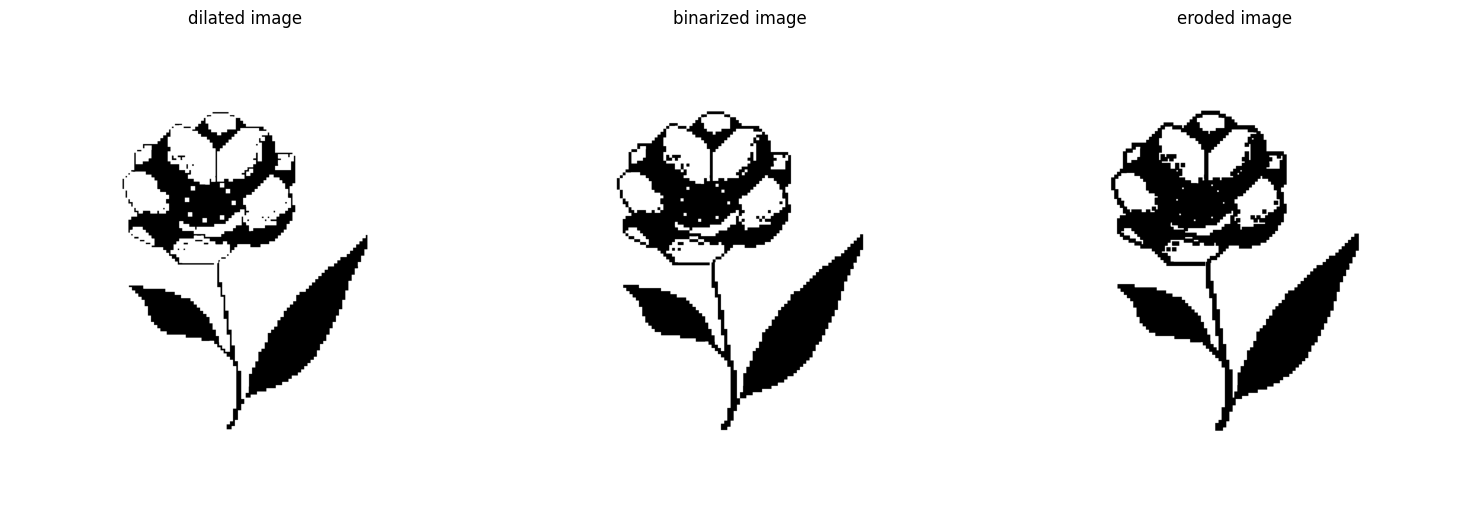

In [42]:
def dilate2(image, radius):
    dilated_image = np.zeros_like(image)

    padded_image = np.pad(image, ((radius, radius), (radius, radius)), mode='constant', constant_values=255)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # sąsiedztwo
            region = padded_image[i:i + 2*radius + 1, j:j + 2*radius + 1]

            # czy jest jakikolwiek jasny piksel
            if np.max(region) > 0:
                dilated_image[i, j] = 255
            else:
                dilated_image[i, j] = 0

    return dilated_image

def erode2(image, radius):
    eroded_image = np.zeros_like(image)

    padded_image = np.pad(image, ((radius, radius), (radius, radius)), mode='constant', constant_values=255)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # sąsiedztwo
            region = padded_image[i:i + 2*radius + 1, j:j + 2*radius + 1]

            # czy wszystkie piksele są jasne
            if np.min(region) == 255:
                eroded_image[i, j] = 255
            else:
                eroded_image[i, j] = 0

    return eroded_image

dilated_img3 = dilate2(img2, radius)
eroded_img3 = erode2(img2, radius)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(dilated_img3, cmap='gray')
axes[0].set_title('dilated image')
axes[0].axis('off')

axes[1].imshow(img2, cmap='gray')
axes[1].set_title('binarized image')
axes[1].axis('off')

axes[2].imshow(eroded_img3, cmap='gray')
axes[2].set_title('eroded image')
axes[2].axis('off')

plt.tight_layout()
plt.show()

otwarcie i domknięcie morfologiczne:

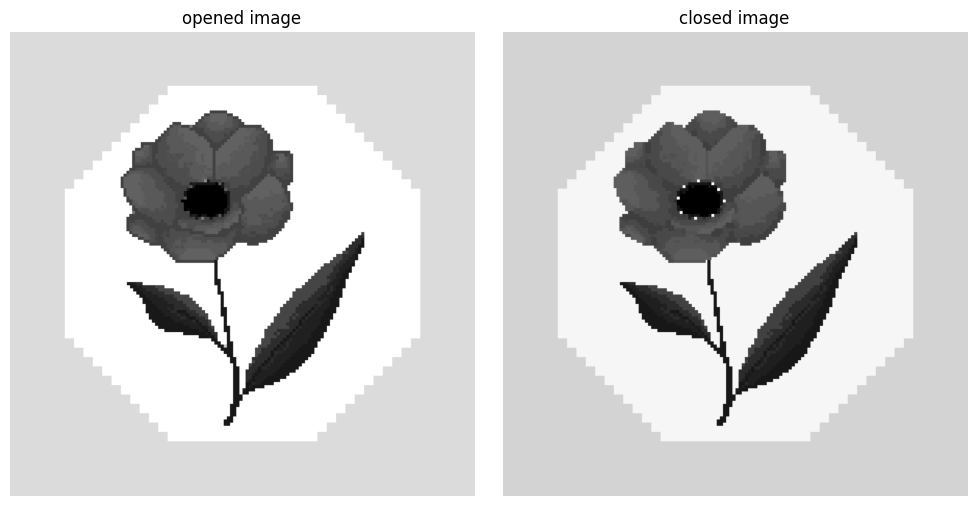

In [43]:
# otwarcie (erozja -> dylatacja)
def opening(image, radius):
    return dilate(erode(image, radius), radius)

# domknięcie (dylatacja -> erozja)
def closing(image, radius):
    return erode(dilate(image, radius), radius)

radius3 = 6

opened_img = opening(img, radius3)
closed_img = closing(img, radius3)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(opened_img, cmap='gray')
axes[0].set_title('opened image')
axes[0].axis('off')

axes[1].imshow(closed_img, cmap='gray')
axes[1].set_title('closed image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# splot funkcji

splot funkcji z maską o promieniu 1 oraz r

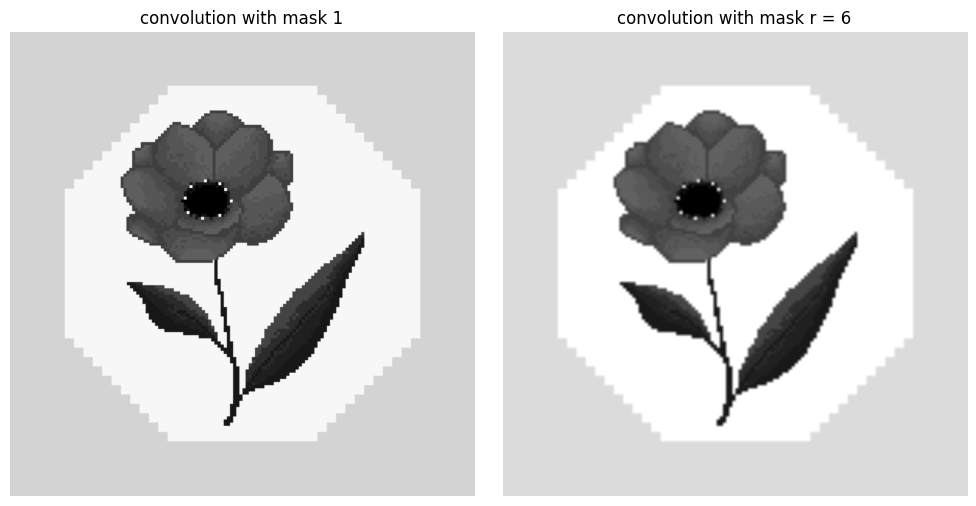

In [44]:
def convolve(image, mask):
    return cv2.filter2D(image, -1, mask)

# maska o promieniu r
def generate_mask(radius):
    size = 2 * radius + 1
    mask = np.ones((size, size), np.float32) / (size * size)
    return mask

# splot z maską o promieniu 1
mask_1 = generate_mask(1)
convolved_img_1 = convolve(img, mask_1)

# splot z maską o promieniu r
rad = 6
mask_r = generate_mask(rad)
convolved_img_r = convolve(img, mask_r)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(convolved_img_1, cmap='gray')
axes[0].set_title('convolution with mask 1')
axes[0].axis('off')

axes[1].imshow(convolved_img_r, cmap='gray')
axes[1].set_title(f'convolution with mask r = {rad}')
axes[1].axis('off')

plt.tight_layout()
plt.show()


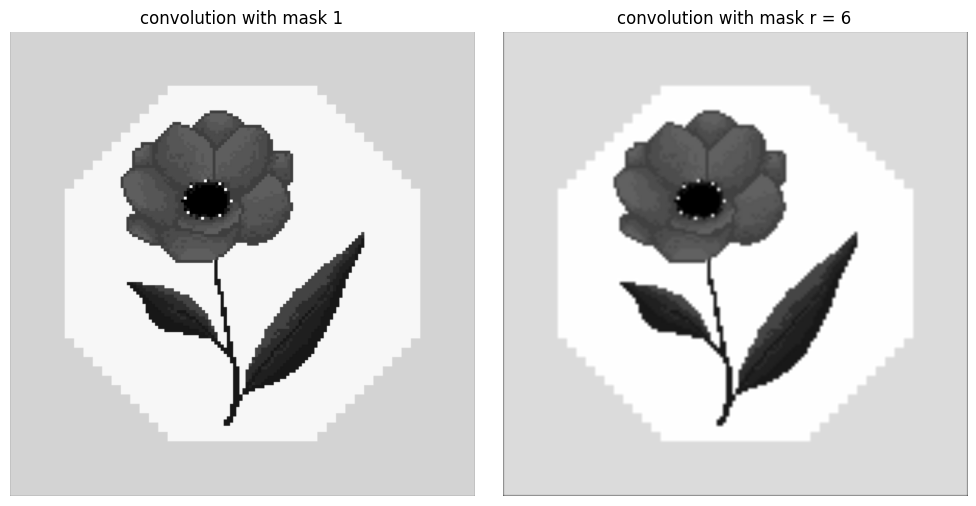

In [45]:
def convolve2(image, mask):
    # rozmiary obrazu i maski
    image_height, image_width = image.shape
    mask_height, mask_width = mask.shape

    # zakładamy nieparzyste wymiary maski
    pad_h = mask_height // 2
    pad_w = mask_width // 2

    # opadany obraz - bo przy operacjach na krawędziach obrazu, maska może wychodzić poza jego granice.
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)

    result = np.zeros_like(image)

    # po każdym pikselu obrazu
    for i in range(image_height):
        for j in range(image_width):
            # sąsiedztwo
            region = padded_image[i:i + mask_height, j:j + mask_width]

            # splot
            result[i, j] = np.sum(region * mask)

    return result


# splot z maską o promieniu 1
convolved_img_1_2 = convolve2(img, mask_1)

# splot z maską o promieniu r
convolved_img_r_2 = convolve2(img, mask_r)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(convolved_img_1_2, cmap='gray')
axes[0].set_title('convolution with mask 1')
axes[0].axis('off')

axes[1].imshow(convolved_img_r_2, cmap='gray')
axes[1].set_title(f'convolution with mask r = {rad}')
axes[1].axis('off')

plt.tight_layout()
plt.show()


Rozszerz implementacje o możliwość zmiany promienia sąsiedztwa dla operacji morfologicznych

In [46]:
# w poprzednich trzeba zmienić odpowiednio radius/radius2/radius3/rad

# maski & filtry

Wczytywania predefiniowanych masek/filtrów o stałym/różnym promieniu z pliku

In [47]:
def load_mask_from_json(file_path, mask_name):
    with open('/content/maski.json', 'r') as jsonfile:
        data = json.load(jsonfile)
    return np.array(data[mask_name])

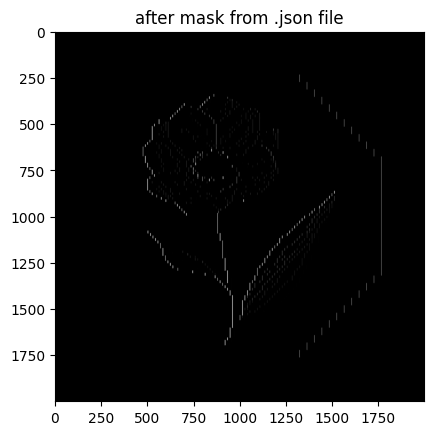

In [48]:
# maski o różnych promieniach
#mask_json = load_mask_from_json('maski.json', 'gauss_3x3')
#mask_json = load_mask_from_json('maski.json', 'v2_5x5')
mask_json = load_mask_from_json('maski.json', 'v3_3x3')

filtered_img_json = convolve(img, mask_json)

plt.imshow(filtered_img_json, cmap='gray')
plt.title("after mask from .json file")
plt.show()

operacja nałożenia filtru gaussa na własnej bitmapie

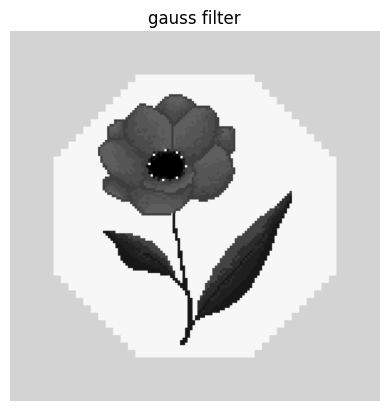

In [49]:
gauss_filter = np.array([ [0.0625, 0.125, 0.0625],
                          [0.125, 0.25, 0.125],
                          [0.0625, 0.125, 0.0625]])

gauss_img = convolve(img, gauss_filter)
plt.imshow(gauss_img, cmap='gray')
plt.title("gauss filter")
plt.axis('off')
plt.show()

3 różne operacje morfologiczne na własnej bitmapie

In [50]:
# jak wyżej

własny filtr dolno-/górnoprzepustowy i zastosuj go na bitmapie z poprzedniego ćwiczenia

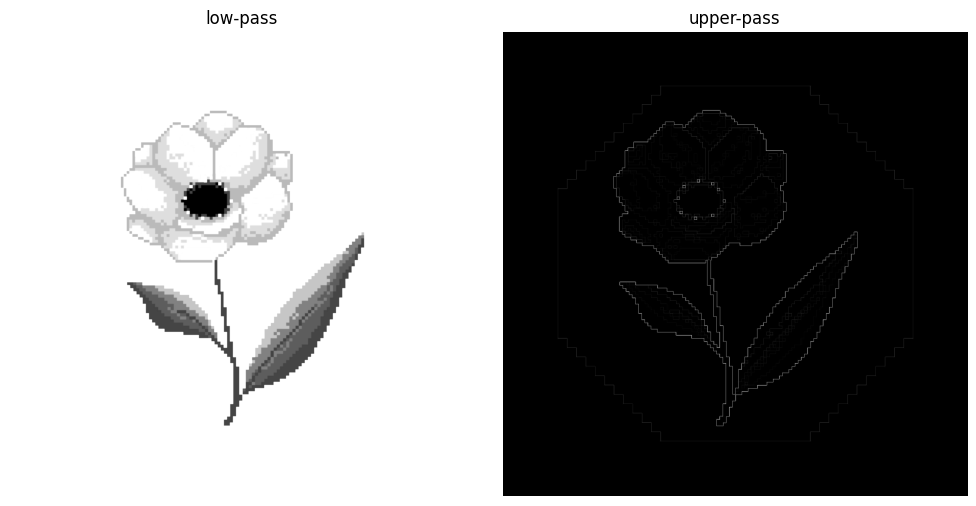

In [51]:
# low-pass
low_pass_filter = np.array([[1, 1, 1],
                            [1, 1, 1],
                            [1, 1, 1]]) / 3
# upper-pass
high_pass_filter = np.array([[-1, -1, -1],
                             [-1,  8, -1],
                             [-1, -1, -1]])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

low_pass_img = convolve(img, low_pass_filter)
axes[0].imshow(low_pass_img, cmap='gray')
axes[0].set_title('low-pass')
axes[0].axis('off')

high_pass_img = convolve(img, high_pass_filter)
axes[1].imshow(high_pass_img, cmap='gray')
axes[1].set_title('upper-pass')
axes[1].axis('off')

plt.tight_layout()
plt.show()